# Problem set 3
#### Machine Learning for Signal Processing E24

*Jakob Sebastian Engel Ketmig*

**s194264**

Due 15th of December, 2024.

In [95]:
# Import relevant libraries.
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io 
from scipy.fft import dct, idct
# Setup params
def setup_mpl():
    mpl.rcParams['font.family'] = 'Times New Roman'
    return None 
setup_mpl()

## 3.1 - Sparse Signal representation

A compressed scenario is considered. We are informed that the signal that has been measured follows the form:

$$\begin{align}
x_n &= \sum^K_{j=1}a_j\cos\bigg(\frac{\pi}{2l}(2m_j-1)n\bigg),~~~n=0,\dots,l-1
\end{align}$$
Furthermore, the total length of the original signal was $l=2^9$. However, only $2^5$ samples were obtained. Note, this signal is sparse for the DCT of $x_n$, ie. $K<<L$.

The sample indices $n$ and sample values $x_n$ are loaded using the file <code>problem3_1.mat</code>.

### 3.1.1 - Recovery of Original Signal Using Sparse Analysis Model

<b>*Describe how you can recover the original signal using a sparse analysis model.  
Explicitly back up your reasoning by referring to signal representation formulas.*</b>

-----------

The general linear algebra problem we aim to solve is:  
$$
A x = b \tag{1}
$$
where $x$ corresponds to the original signal $x_n \in \mathbb{R}^{1 \times l}$, and $b$ represents the measurements $b \in \mathbb{R}^{1 \times m}$. Given that $A$ and $b$ are known, recovering the original signal $x$ is generally possible. However, because $25 = m < l = 29$, the system is underdetermined, meaning that the solution for $x$ lies in an $(l-m)$-dimensional sub-manifold. 

If we assume that $x$ is sparse (i.e., it has few non-zero elements), we can exploit this property to recover a more exact solution. This approach is commonly referred to as *compressed sensing*.

In this case, we are informed that $x_n$ is sparse in the Discrete Cosine Transform (DCT) domain. We can relate this to equation $(1)$ by defining a sensing matrix $A$ to model the observations:
$$
A x_n = b \tag{2}
$$

To leverage sparsity, we define a dictionary matrix $\Psi$ that describes the Inverse Discrete Cosine Transform (IDCT) domain (mapping from the DCT domain back to the time domain), and a vector $\theta$ that represents the DCT coefficients of the original signal $x_n$ in a sparse representation. The relationship is expressed in eq. (9.37) in the ML book:
$$
x_n = \Psi \theta, \quad \text{s.t.} \quad b = A x_n = A \Psi \theta \tag{3}
$$

Here, $\theta$ captures the sparse structure of the signal in the DCT domain, while $\Psi$ transforms these coefficients back to the time domain. This formulation allows us to solve for $\theta$ and subsequently reconstruct $x_n$.



### 3.1.2 - Estimate parameters using appropriate sparsity-promoting algorithm.

<b>*Use an approproate sparsity promoting algorithm and estimate the following parameters explicitly using 2 digits: $K$, $a_j$ and $m_j$ . Submit the code and write comments on key operations.*</b>

-----------

First we plot the data provided:

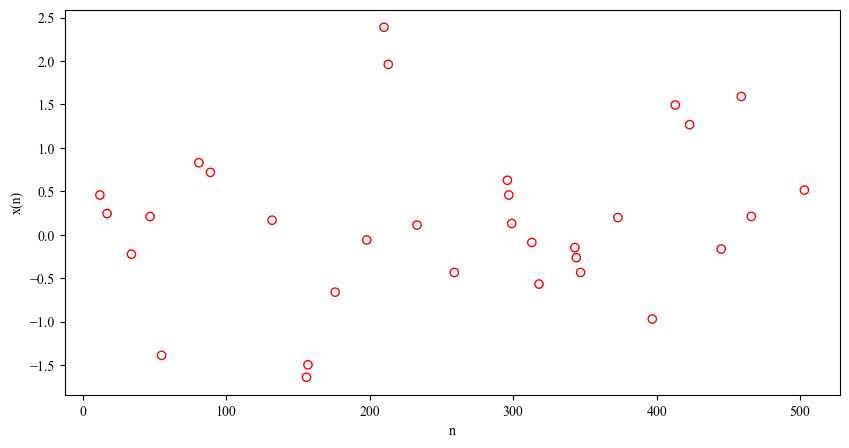

In [96]:
# Recreating the data from Figure 1 in problem definition.
data = scipy.io.loadmat('problem3_1.mat')
n = data['n'].squeeze()
x = data['x'].squeeze()
N = len(n)
l = 2**9
# Plotting data...
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
ax.scatter(n, x, edgecolor='red', marker='o', facecolors='none') 
ax.set_xlabel('n') 
ax.set_ylabel('x(n)')
plt.show()

A variety of methods can be considered for this problem; one such method is the greedy *Orthogonal Matching Pursuit* (OMP) scheme, as described in Algorithm 10.1 of the ML book. OMP is an iterative heuristic solution for the $\ell_0$-norm that identifies the sparsest solution by iteratively selecting the components with the highest correlation to the respective error vector. This makes OMP well-suited for sparsity-aware learning problems like this one, where the signal is sparse in the DCT domain.

The $\ell_0$-norm effectively counts the number of non-zero elements in a vector, which aligns with our objective of recovering a sparse solution. However, it is important to note that the $\ell_0$-norm is non-convex, which can make the problem computationally challenging. In comparison, algorithms such as *Iterative Shrinkage and Thresholding* (IST) solve a convex relaxation of the problem using the $\ell_1$-norm, which promotes sparsity, but may not find the sparsest solution unless special conditions are met.

One may recall from slide 24 of Week 6 that the $\ell_p$-norms ($p < 1$) are non-convex and therefore are not true norms. This highlights the "*no free lunch*" phenomenon, as convexity must often be traded for sparsity in these types of optimization problems. Furthermore, the computational efficiency of OMP is known to be better than that of the IST algorithm, though it sacrifices guaranteed optimality. The theoretical guarantees for the performance of the OMP-algorithm are provided under specific conditions outlined in Theorem 10.1 in the ML book. 

In the following both the OMP and IST will be implemented and their solutions compared in extension of the discussion above, however the choice initially is the OMP due to leveraging sparsity over convexity. Here the number of iterations $k$ is preselected, determining the sparsity of the solution. This value was selected by inspecting the scale of the active coefficients using different values, and choosing the sparsest one which gave a reasonable reconstruction of the original signal. However, one way to estimate a reasonably valid $k$ is to inspect the error between the measurements and their reconstruction:

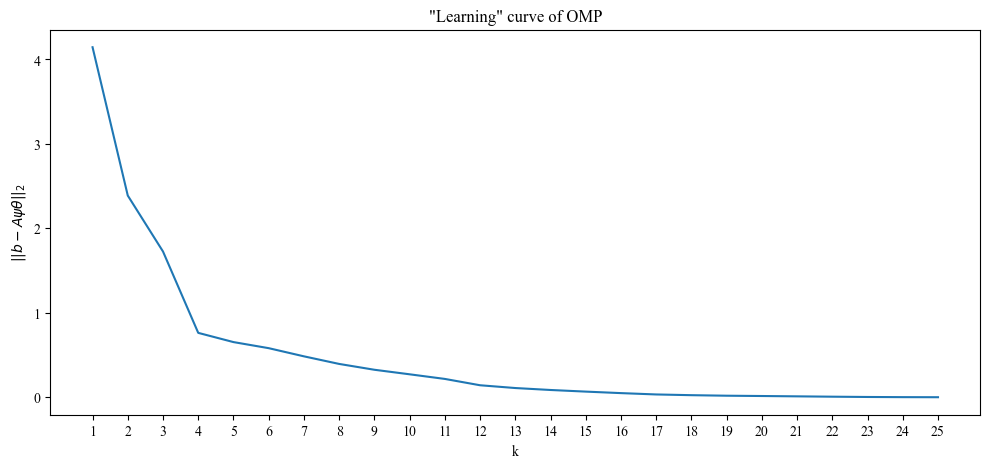

Text(0.5, 1.0, 'Estimated OMP Solutions ($k=4$)')

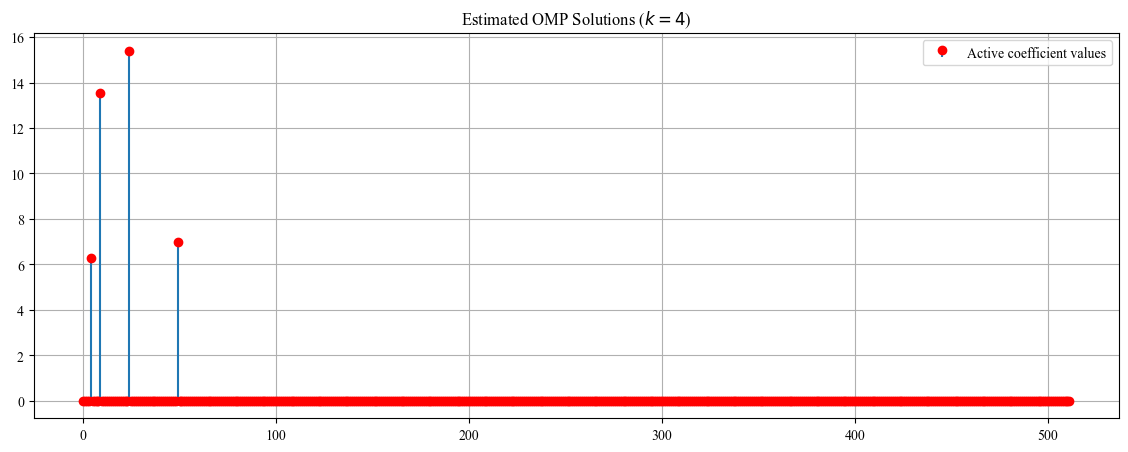

In [97]:
def OMP(k):
    # Constructing sending matrix, A. (X in book)
    A = np.zeros((N, l))
    for i in range(N):
        A[i, n[i]] = 1
    # Transformation matrix (IDCT)
    xjc = idct(A, norm='ortho') # x_j^c in book
    # OMP Algorithm (10.1)
    #k = No. steps
    e = x # Initial error vector (e=y in the book)
    S = np.zeros(k, dtype=int) # Support set (Ø initially)
    normXjc = np.linalg.norm(xjc)
    error_i = []
    for i in range(k):
        # Normalized projection
        p = (xjc.T @ e) / normXjc
        # Select column with smallest angle with error (max projection value)
        j_i = np.argmax(np.abs(p))
        # Update indices of support set S(i) and corresponding active columns of A
        S[i] = j_i
        xjc_i = xjc[:, S[:i+1]]
        # Update the LS estimate minimizing norm of error given active columns of A
        theta_tilde = np.linalg.solve(xjc_i.T @ xjc_i, xjc_i.T @ x)
        theta_i = np.zeros(xjc.shape[1])
        # Update parameters by inserting into supported indices
        theta_i[S[:i+1]] = theta_tilde
        # Update error vector
        e = x - xjc@theta_i
        error_i.append(np.linalg.norm(x - xjc@theta_i))
    
    return theta_i, error_i

# "Learning" curve for k-values
k_max = 25
_, errors_k = OMP(k=k_max) # Calculate parameter estimates and compare to measurements b

fig, ax = plt.subplots(figsize=(12,5))
ax.plot([i+1 for i in range(0, k_max)], errors_k)
ax.set_ylabel(r'$||b- A\psi\theta||_{2}$')
ax.set_xlabel('k')
ax.set_title('"Learning" curve of OMP') 
ax.set_xticks([i+1 for i in range(0, k_max)])
plt.show()

# Using k = 4
k = 4
theta_i, error_i = OMP(k)
# Plot active coefficient indices of estimated solution
fig, ax= plt.subplots(1, 1, figsize=(14, 5))
ax.stem(theta_i, markerfmt='ro', label='OMP', basefmt=' ')
ax.legend(['Active coefficient values'])
ax.grid()
ax.set_title(r'Estimated OMP Solutions ($k=4$)')

The original signal may be recovered by using the $j$'th column of the sensing matrix $a_j$ and the $j$'th component of the measurement vector $b$ given by $m_j$:

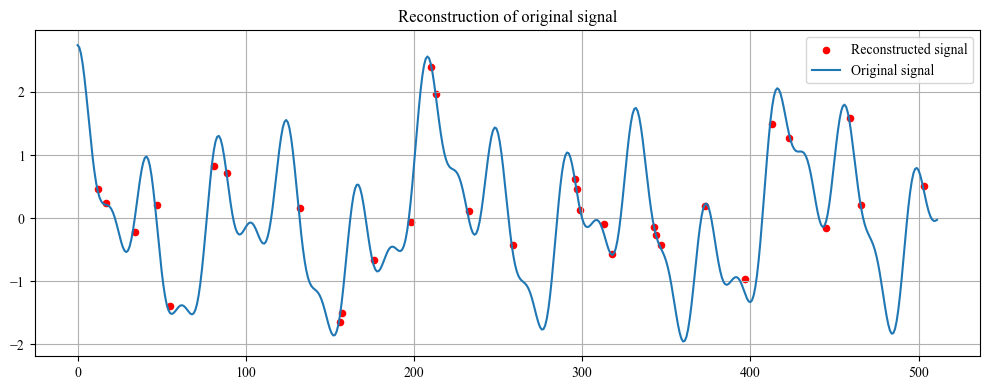

Preselected value of k: 4
a_j: [0.41, 0.88, 1.0, 0.45]
m_j: [5, 10, 25, 50]


In [98]:
m = np.where(theta_i != 0)[0] # Active indices
a = theta_i[m] / theta_i[m].max() # Active coefficients
m += 1

x_hat = np.zeros(l)
for n_ in range(l):
    for j in range(k):
        # Problem definition: Original signal form
        x_hat[n_] += a[j] * np.cos( (np.pi/(2*l)) * (2*m[j] - 1) * n_)

# Reconstructed signal plot
fig, ax= plt.subplots(figsize=(10, 4))
ax.scatter(n, x, c='r', s=20)
ax.plot(x_hat)
ax.set_title('Reconstruction of original signal')
ax.grid()
ax.legend(['Reconstructed signal', 'Original signal'])
fig.tight_layout()
plt.show()

# Parameter estimates:
print(f"Preselected value of k: {k}")
print(f"a_j: {[round(val.item(),2) for val in a]}")
print(f"m_j: {[round(val.item(),2) for val in m]}") # NOTE: +1 if MATLAB indexing

This provides a reasonable fit, although slight deviations can be observed, the most egregious one being present at around index 400. Here $m_j$ is assumed 0-indexed, which is unlike the standard found in MATLAB.

Comparing with the IST algorithm the same pattern is observed if too high of a $k$-value was chosen in the OMP algorithm, namely a noisier reconstruction with a less sparse solution.

No. non-zero coefficients (IST): 36


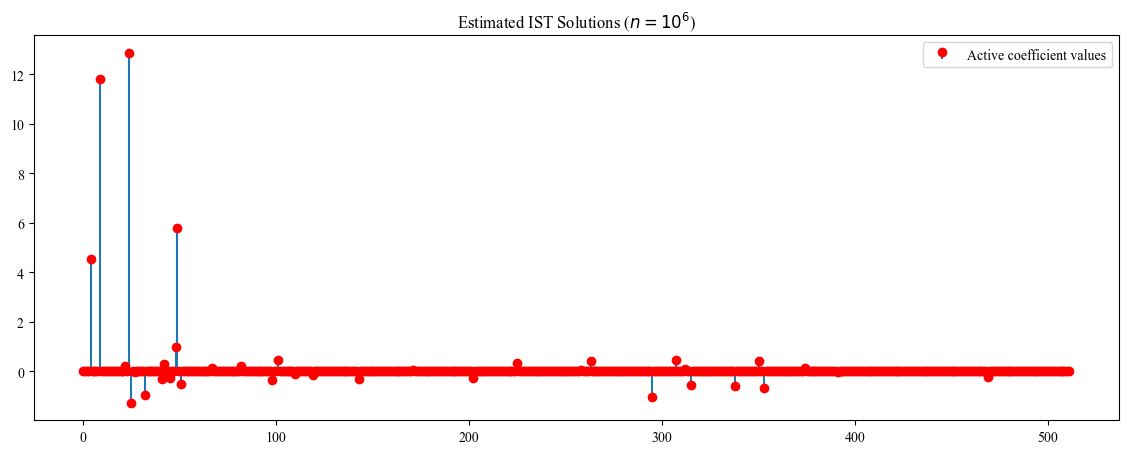

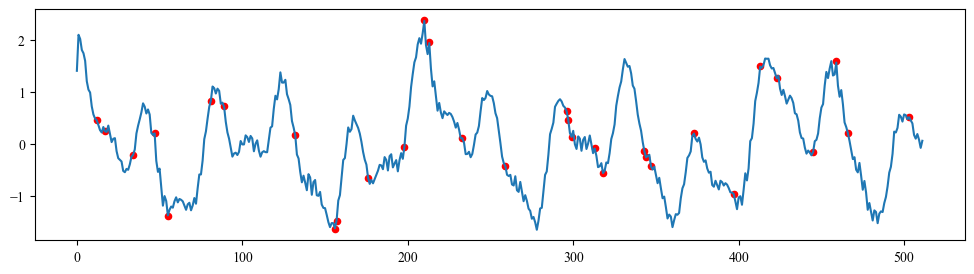

In [106]:
# hyperparameters
lambda_ = 5e-3 # regularization
mu = 0.1 # step size

def IST(lambda_, mu, n_steps):
    t = np.zeros((l, n_steps))
    for i in range(1, n_steps):
        e = x - xjc@t[:, i-1]
        t_tilde = t[:, i-1] + mu * xjc.T @ e
        t[:, i] = np.sign(t_tilde) * np.maximum(np.abs(t_tilde) - mu * lambda_, 0)
    return t[:, -1]

ist = IST(lambda_, mu, 10**5) # 1 million

fig, ax= plt.subplots(1, 1, figsize=(14, 5))
ax.stem(ist, markerfmt='ro', label='IST', basefmt=' ')
ax.legend(['Active coefficient values'])
ax.set_title('Estimated IST Solutions ($n=10^6$)') 

print(f"No. non-zero coefficients (IST): {len(np.where(ist!=0)[0])}")


# Take the inverse IDCT (i.e. the DCT) in order to compute the estimated signal. 
x_hat = dct(ist, norm='ortho') 
fig, ax= plt.subplots(figsize=(12, 3))
ax.scatter(n, x, c='r', s=20)
ax.plot(x_hat)


## 3.2 - Bayesian inference and the EM algorithm

Consider the regression problem:

$$
y_n = \mathbf{\theta}^T\mathbf{x}_n+\eta_n \tag{4},
$$
where $\eta_n$ is independently and identically distributed (i.i.d.) and $\eta_n \sim \mathcal{N}(0,\sigma_\eta^2)$. Additionally, we also assume the elements of $\mathbf{\theta}$ are also i.i.d. and $\theta_i \sim \mathcal{N}(0,\sigma_\theta^2)$.

The parameters $\mathbf{\theta}$ can be found by solving the following optimization problem:

$$
\hat{\theta} = \argmin_\theta \frac{1}{2\sigma_\eta^2}||\mathbf{y}-X\mathbf{\theta}||^2_2 + \frac{1}{2\sigma^2_\theta}||\mathbf{\theta}||^2_2, \tag{5}
$$
where $\mathbf{y}=[y_1,y_2,\dots,y_N]^T$ and $X=[x_1,x_2,\dots,x_N]^T$.

### 3.2.1 - Identify and describe the optimization problem

<b>*Identify the problem equation (5) solves, and the role of its terms with respect to likelihood, prior, regularization and mean square error (MSE). How will the values of $\sigma_\eta$ and $\sigma_\theta$ influence the optimization problem?*</b>

------------

The optimization problem resembles the ridge regression problem given initially as eq. (3.41) and its vector form in chapter 6.5 in the ML book:

$$
\hat{\theta}_R = \argmin_\theta\bigg\{||\mathbf{y}-X\mathbf{\theta}||^2+\lambda||\mathbf{\theta}||^2\bigg\} \tag{6},
$$
where $\lambda>0$ is a user-defined parameter that controls the contribution of the regularization term. This in turn imposes some bias to the least squares (LS) solution by minimizing the $\ell_2$-norm of $\theta$.

Although the main part of its derivation will be omitted here, the reader may recall exercise 9.1.4 which examined the case of a normal log-prior with statistically independent weights with zero mean was explored. It was demonstrated that by reparametrizing $\sigma_\theta^2=\frac{\sigma_\eta^2}{\lambda}\Leftrightarrow\lambda=\frac{\sigma_\eta^2}{\sigma_\theta^2}$ and substituting into the optimization problem yields:

$$\begin{align*}
\hat{\theta} &= \argmin_\theta \frac{1}{2\sigma_\eta^2}||\mathbf{y}-X\mathbf{\theta}||^2_2 + \frac{1}{2\frac{\sigma_\eta^2}{\lambda}}||\mathbf{\theta}||^2_2 \\
&= \argmin_\theta \frac{1}{2\sigma_\eta^2}||\mathbf{y}-X\mathbf{\theta}||^2_2 + \frac{\lambda}{2\sigma_\eta^2}||\mathbf{\theta}||^2_2
\\
&= \argmin_\theta ||\mathbf{y}-X\mathbf{\theta}||^2_2 + \lambda||\mathbf{\theta}||^2_2
\end{align*},$$
which is readily recognizable as ridge regression. Since the optimization is w.r.t. $\theta$ one may disregard factors that do not impact its solution. Furthermore, the relationship between the noise of the data and the weights as given by $\lambda$ is noteworthy. If the data contains a lot noise, ie. $\sigma_\eta^2$ is large, then regularization given $\lambda$ increases to avoid overfitting. Conversely, if uncertainty in the prior ($\sigma_\theta^2$) is small, then $\lambda$ is as well.  

### 3.2.2 - Find expression for $\ln p(z|a,b)$.

<b>*Before $\sigma_\eta^2$ was assumed known. However, in order to estimate it in a Bayesian manner we impose an inverse gamma prior on $\sigma_\eta^2$. Find an expression for $\ln p(z|a,b)$. Omit additive terms that are not dependent on z.*</b>

$$
p(z|a,b) = \frac{b^a}{\Gamma(a)}z^{-a-1}\exp\bigg(-\frac{b}{z}\bigg),
$$
where $a>0$ and $b>0$ are hyperparameters and $\Gamma(\cdot)$ is defined as:
$$
\Gamma(x)=\int^\infty_0 y^{x-1}e^{-y} \text{d}y
$$

--------------



Deriving the expression using logarithmic rules of expansion:
$$\begin{align*}
\ln p(z|a,b) &= \frac{b^a}{\Gamma(a)}z^{-a-1}\exp\bigg(-\frac{b}{z}\bigg)
\\
&= \ln \bigg(\frac{b^a}{\Gamma(a)}\bigg) + \ln\bigg(z^{-a-1}\bigg) + \bigg( -\frac{b}{z}\bigg) 
\\
&= (-a-1)\ln(z)- \frac{b}{z} ~~~~ \text{(Omission of non-z dependent terms.)}
\\
&= - (a+1)\ln(z)- \frac{b}{z}
\end{align*}$$

### 3.2.3 - Bayes Theorem

<b>*Introducing a prior on $\sigma_\eta^2$ in the loss function and using Bayes' theorem, show that the following posterior is true. Write out the log-posterior by inserting the corresponding distributions.*</b>

$$
p(\mathbf{\theta},\sigma_\eta^2|\mathbf{y}) = \frac{p(\mathbf{y}|\sigma_\eta^2,\mathbf{\theta})p(\sigma_\eta^2)p(\mathbf{\theta})}{p(\mathbf{y})}
$$

----------

Recall that Bayes' theorem is given by (2.14) in the ML book:

$$
P(A|B)=\frac{P(B|A)P(A)}{p(B)}
$$
Equivalently, given the problem definition:
$$\begin{align*}
\ln p(\mathbf{\theta},\sigma_\eta^2|\mathbf{y}) &= \frac{\ln p(\mathbf{y}|\sigma_\eta^2,\mathbf{\theta})\ln p(\sigma_\eta^2,\mathbf{\theta})}{\ln p(\mathbf{y})}
\\
&= \frac{\ln p(\mathbf{y}|\sigma_\eta^2,\mathbf{\theta}) \ln p(\sigma_\eta^2|\mathbf{\theta}) \ln p(\mathbf{\theta})}{\ln p(\mathbf{y})} \tag{\text{Product rule}}
\\
&=\frac{\ln p(\mathbf{y}|\sigma_\eta^2,\mathbf{\theta}) \ln p(\sigma_\eta^2) \ln p(\mathbf{\theta})}{\ln p(\mathbf{y})} \tag{\text{Independence rule}}
\\
&= \ln p(\mathbf{y}|\sigma_\eta^2,\mathbf{\theta}) + p(\sigma_\eta^2) + \ln p(\mathbf{\theta}) - \ln p(\mathbf{y})
\\
&\propto \ln p(\mathbf{y}|\sigma_\eta^2,\mathbf{\theta}) + p(\sigma_\eta^2) + \ln p(\mathbf{\theta}) \tag{\text{Prior $p(y)$ constant}}
\\
&= -\frac{1}{2\sigma^2_\eta}||\mathbf{y}-X\mathbf{\theta}||^2_2 - (a+1)\ln(\sigma_\eta^2) - \frac{b}{\sigma_\eta^2} - \frac{1}{2\sigma_\theta^2}||\mathbf{\theta}||_2^2
\end{align*}$$
Note that the variance of the noise is now also estimated. The maximum a posteriori (MAP) estimate w.r.t. $\theta$ and $\sigma_\eta^2$ is given by eq. (3.75) in the book. Much like in exercise 9 we may rewrite s.t. the maximization problem becomes a minimization one instead by negating the objective function:

$$\begin{align*}

\hat{\theta}_{MAP} &= \argmax_{\theta,\sigma_\eta^2}\{\ln p(\mathbf{\theta},\sigma_\eta^2|\mathbf{y})\}
\\
&= \argmin_{\theta,\sigma_\eta^2}\bigg\{\ \frac{1}{2\sigma^2_\eta}||\mathbf{y}-X\mathbf{\theta}||^2_2 + (a+1)\ln(\sigma_\eta^2) + \frac{b}{\sigma_\eta^2} + \frac{1}{2\sigma_\theta^2}||\mathbf{\theta}||_2^2\bigg\}
\end{align*}$$



## 3.3 - Estimation of ICA solution

Recall the ICA model is given by 

$$
\mathbf{x}=A\mathbf{s}
$$
where $N$ realizations of the random vector $\mathbf{x}$ is observed. Recovering the mixing matrix $A$ assuming it is square invertible, ie. $\mathbf{z}=W\mathbf{x}=WA\mathbf{s}$, where $W=A^{-1}$ when perfect recovery is obtained. For the entirety of the problem it is given $A=[\mathbf{a}_1~~\mathbf{a}_2]=\begin{bmatrix}3 & 1 \\ 1 & 1\end{bmatrix}$

### 3.3.1 - Estimate $\hat{A}$ using ICA if $s\sim U(0,1)$.

<b> *Create a program that estimates $\hat{A}$ using ICA with mutual information (as in the exercise), and create a function that calculates the error between $A$ and $\hat{A}$. It should take into account hat ICA can neithe estimate the magnitude of the vectors in $A$, nor the ordering of the basis vectors. Validate that you get a "low error" in this setup.*

*Make plots of the following: the sources ($s$), the observations ($x$), the estimated sources ($\hat{s}$). Plot or compute the error of $\hat{A}$ based on 100 repeated experiments.*</b>

-----------

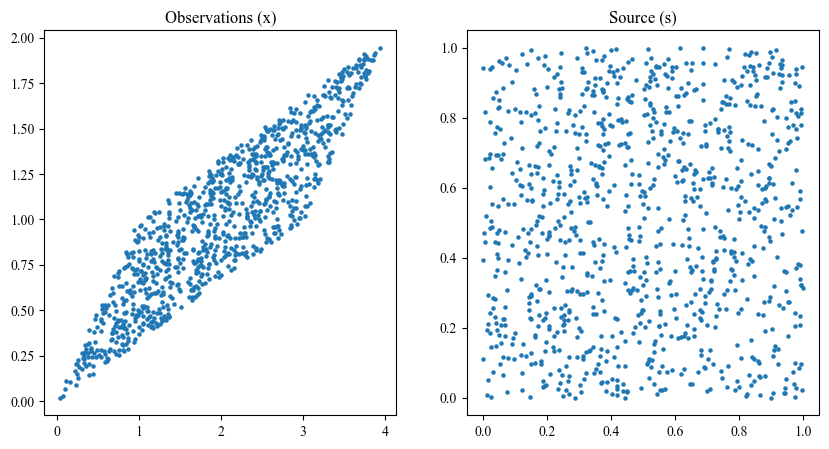

In [ ]:
def ICA(x, mu, n_components, iters, mode):
    # Given equation (16.60) in the ML book (exercise 8.3)
    W = np.random.rand(n_components, n_components)
    N = x.shape[0]
    if mode == 'superGaussian':
        phi = lambda u : 2 * np.tanh(u)
    elif mode == 'subGaussian':
        phi = lambda u : u - np.tanh(u)
    else:
        raise ValueError('Invalid type')
    
    for _ in range(iters):
        u = W @ x.T # z
        dW = (np.eye(n_components) + (phi(u)@u.T / N) @ W )
        W += mu * dW
    return W

# Generate data for ICA given problem definition(s)
N = 1000
A = np.array([[3, 1], 
              [1, 1]])
s = np.random.uniform(0, 1, (N, 2))
x = (A@s.T).T

# Plotting
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.scatter(x[:,0], x[:,1], s=5)
ax1.set_title(r'Observations (x)') 
ax2.scatter(s[:,0], s[:,1], s=5)
ax2.set_title(r'Source (s)')
plt.show()
